#### Install and import libraries

In [0]:
!pip install joblib

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import re

import nltk
nltk.download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import joblib
from sklearn.externals import joblib

from google.colab import files

#### Upload files to azure cloud platform



In [0]:
from azure.storage.blob import BlockBlobService

account_name='bricen'
account_key='N0ZNhw3i1xpnCxq5luWE2Sn3ZN88eKJn1PYqR3XxXR3nmqIzsD0rGWcL4Ul8AiSYciTqYHwugJPIxqfxWvKB9A=='

service_blob = BlockBlobService(account_name, account_key) 

In [0]:
import glob

files_to_upload = glob.glob('/content/*.csv')
files_to_upload

In [0]:
service_blob.create_container('nlpreco')
container_name = 'nlpreco'
for item in files_to_upload:  
  source_file_path = item
  destination_file_path = item.rpartition('/')[-1]
  service_blob.create_blob_from_path(container_name, destination_file_path, source_file_path)

#### Upload files from local disk

In [0]:
from google.colab import files
uploaded = files.upload()

- There are 5 datasets in total

  - The *Combined_Jobs_Final.csv*, *Experience.csv*, *Job_Views.csv*, *Positions_Of_Interest.csv* datasets were taken from this [Kaggle Challenge](https://kaggle.com/kandij/job-recommendation-datasets)
  - The *Jobs2.csv* dataset was taken from [here](https://www.kaggle.com/chadalee/text-analytics-explained-job-description-data/data)

- These datasets can be separated in two groups:
  - Jobs datasets (*Combined_Jobs_Final.csv*, *Train_rev1.csv* renamed as *Jobs2.csv*)
  - Applicants datasets (*Experience.csv*, *Job_Views.csv*, *Positions_Of_Interest.csv*)

- The following steps will consist of cleaning the datasets and combine them if they are in the same group


Here are the preprocessing steps to follow for each dataframe:
- Drop unwanted columns
- Impute missing values
- Transform all text to lower case
- Remove punctuation signs
- Remove stop words
- Tokenization
- Lemmetization

In [0]:
# Preprocessing function

def text_preproc(row):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer() 

  row = re.sub(r'\W+', ' ', row)   # remove non aphanumeric characters
  row = row.replace('\r', '')      # remove \r
  row = row.replace('\n', '')      # remove \n
  row = row.replace('\d+', '')     # remove numbers
  row = re.sub(r'[^\w\s]','', row) # remove punctuations
  row = ' '.join([item for item in word_tokenize(row) if item not in stop_words]) # tokenization
  row = row.lower()                # put all words in lowcase
  row = lemmatizer.lemmatize(row)  # lemmatization
  return row

#### Clean the Combined_Jobs_Final dataframe

In [0]:
# csv file containing job offers info

df_jobs = pd.read_csv('Combined_Jobs_Final.csv')
df_jobs.head()

In [0]:
# Drop unecessaray columns

df_jobs.drop(columns=['Provider', 
                      'Status', 
                      'Slug', 
                      'State.Code', 
                      'Address', 
                      'Industry', 
                      'Requirements', 
                      'Salary', 
                      'Listing.Start', 
                      'Listing.End', 
                      'Created.At', 
                      'Updated.At'], inplace=True)

In [0]:
# Rename columns

df_jobs.rename(columns={'Job.ID':'Job_ID', 
                       'State.Name':'State', 
                       'Job.Description':'Description',
                       'Employment.Type':'Employment',
                       'Education.Required':'Education'}, inplace=True)

In [0]:
# Change value in Employment column to be consistent

df_jobs["Employment"]= df_jobs.Employment.replace('Temporary/seasonal', 'Seasonal/Temp')

In [0]:
# Impute missing values

df_jobs['Description'] = df_jobs.Description.fillna('')
df_jobs['Employment'] = df_jobs.Employment.fillna('')
df_jobs['Education'] = df_jobs.Education.fillna(df_jobs.Education.mode().iloc[0])
df_jobs['Company'] = df_jobs.Company.fillna('')
df_jobs['City'] = df_jobs.City.fillna('')
df_jobs['State'] = df_jobs.State.fillna('')

In [0]:
# Remove company name from the job title
df_jobs['Title'] = df_jobs.apply(lambda x: x.Title.replace(x.Company, ''), axis=1)

# Apply the text_preproc function to the columns with text
df_jobs['Title'] = df_jobs.Title.apply(text_preproc)
df_jobs['Position'] = df_jobs.Position.apply(text_preproc)
df_jobs['Company'] = df_jobs.Company.apply(text_preproc)
df_jobs['City'] = df_jobs.City.apply(text_preproc)
df_jobs['State'] = df_jobs.State.apply(text_preproc)
df_jobs['Description'] = df_jobs.Description.apply(text_preproc)
df_jobs['Employment'] = df_jobs.Employment.apply(text_preproc)
df_jobs['Education'] = df_jobs.Education.apply(text_preproc)

#### Cleaning the Jobs2 dataframe

In [0]:
# csv files containing ob offers info

df_jobs2 = pd.read_csv('Jobs2.csv') 
df_jobs2.head(2)

In [0]:
# Drop unecessaray columns

df_jobs2.drop(columns=['LocationRaw',
                      'ContractTime',
                      'Category', 
                      'SalaryRaw', 
                      'SalaryNormalized', 
                      'SourceName'], inplace=True)

In [0]:
# Rename columns

df_jobs2.rename(columns={'Id':'Job_ID', 
                         'State.Name':'State', 
                         'FullDescription':'Description',
                         'LocationNormalized':'City',
                         'ContractType':'Employment'}, inplace=True)

In [0]:
np.where(df_jobs2.Title.isna())

In [0]:
# Create new columns in df_jobs2 dataset to match that in df_jobs

df_jobs2['Education'] = 'Not Specified'
df_jobs2['Latitude'] = ''
df_jobs2['Longitude'] = ''
df_jobs2['State'] = ''

# Change the Employment columns values of the df_jobs2 to match that of the df_jobs dataframe

df_jobs2["Employment"]= df_jobs2.Employment.replace('full_time', 'Full-Time')
df_jobs2["Employment"]= df_jobs2.Employment.replace('part_time', 'Part-Time')

# Impute missing values

df_jobs2['Employment'] = df_jobs2.Employment.fillna('')
df_jobs2['Company'] = df_jobs2.Company.fillna('')

# Impute a missing value based on the other columns

df_jobs2.Title[1588] = 'Quality Improvement Manager'

In [0]:
# Remove 'Position:' in the Job_Descriptions
df_jobs2['Description'] = df_jobs2.Description.apply(lambda row: row.replace('Position:', ''))

# Create the Position column
df_jobs2['Position'] = df_jobs2.apply(lambda x: x.Title.replace(x.City, ''), axis=1)

# Apply the text_preproc function to the columns with text
df_jobs2['Title'] = df_jobs2.Title.apply(text_preproc)
df_jobs2['Description'] = df_jobs2.Description.apply(text_preproc)
df_jobs2['Position'] = df_jobs2.Position.apply(text_preproc)
df_jobs2['City'] = df_jobs2.City.apply(text_preproc)
df_jobs2['Employment'] = df_jobs2.Employment.apply(text_preproc)
df_jobs2['Company'] = df_jobs2.Company.apply(text_preproc)
df_jobs2['Education'] = df_jobs2.Education.apply(text_preproc)

In [0]:
# Reorganize columns orders to match df_jobs

df_jobs2 = df_jobs2[['Job_ID', 'Title', 'Position', 'Company', 'City', 'State', 'Latitude', 'Longitude', 'Description', 'Employment', 'Education']]

In [0]:
df_jobs2.head(2)

#### Concatenate the two jobs datasets

In [0]:
jobs_dataset = pd.concat([df_jobs, df_jobs2], ignore_index=True)
jobs_dataset.drop(columns=['Title'], inplace=True)
jobs_dataset.to_csv("jobs.csv", index=False)

In [0]:
# download the job dataset for the TFIDF modelon local disk

files.download('jobs.csv')

In [0]:
# Upload the job dataset for the TFIDF model to Azure cloud platform

from azure.storage.blob import BlockBlobService

account_name='bricen'
account_key='N0ZNhw3i1xpnCxq5luWE2Sn3ZN88eKJn1PYqR3XxXR3nmqIzsD0rGWcL4Ul8AiSYciTqYHwugJPIxqfxWvKB9A=='
service_blob = BlockBlobService(account_name, account_key)

import glob
files_to_upload = 'jobs.csv'
files_to_upload

container_name = 'nlpreco'
for item in files_to_upload:  
  source_file_path = files_to_upload
  destination_file_path = 'jobs.csv'
  service_blob.create_blob_from_path(container_name, destination_file_path, source_file_path)
  service_blob.create_blob_from_path(container_name, destination_file_path, source_file_path)

#### Clean the Experience dataframe

In [0]:
# csv file containing the professional experience of the Applicants

df_exp = pd.read_csv('Experience.csv')
df_exp.head(2)

In [0]:
# Drop unecessaray columns

df_exp.drop(columns=['State.Code',
                     'Start.Date',
                      'End.Date',
                      'Salary', 
                      'Can.Contact.Employer', 
                      'Created.At', 
                      'Updated.At'], inplace=True)

In [0]:
# Rename columns

df_exp.rename(columns={'Applicant.ID':'Applicant_ID', 
                       'Employer.Name':'Company', 
                       'Position.Name':'Position', 
                       'Job.Description':'Description', 
                       'State.Name':'State'}, inplace=True)

In [0]:
# Impute missing values

df_exp['Position'] = df_exp.Position.fillna('')
df_exp['Company'] = df_exp.Company.fillna('')
df_exp['City'] = df_exp.City.fillna('')
df_exp['State'] = df_exp.State.fillna('')
df_exp['Description'] = df_exp.Description.fillna('')

In [0]:
# Apply the text_preproc function to the columns with text

df_exp['Position'] = df_exp.Position.apply(text_preproc)
df_exp['Company'] = df_exp.Company.apply(text_preproc)
df_exp['City'] = df_exp.City.apply(text_preproc)
df_exp['State'] = df_exp.State.apply(text_preproc)
df_exp['Description'] = df_exp.Description.apply(text_preproc)

In [0]:
# Add a suffix to the column names of the experience dataset

col_names = ['Position', 'Company', 'City', 'State', 'Description']
col_new_names = [name+'_before' for name in col_names]
   
for i in range(len(col_names)):
  df_exp.rename(columns={col_names[i]:col_new_names[i]}, inplace=True)

#### Clean the *Job_views* dataframe



In [0]:
# csv file containing info about the job viewed by the applicants

df_views = pd.read_csv('Job_Views.csv')
df_views.head(2)

In [0]:
# Drop unecessaray columns

df_views.drop(columns=['Title',
                       'Job.ID',
                       'State.Code',
                       'Industry',
                       'View.Start',
                       'View.End', 
                       'Created.At', 
                       'Updated.At'], inplace=True)

In [0]:
# Rename columns

df_views.rename(columns={'Applicant.ID':'Applicant_ID',
                         'State.Name':'State',
                         'View.Duration':'View_Duration'}, inplace=True)

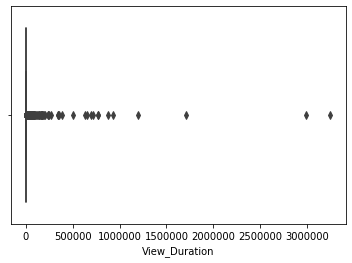

In [0]:
sns.boxplot(df_views.View_Duration)

In [0]:
# Impute missing values

df_views['Company'] = df_views.Company.fillna('')
df_views['State'] = df_views.State.fillna('')
df_views['View_Duration'] = df_views.View_Duration.fillna(df_views.View_Duration.median())

In [0]:
df_views.head(2)

In [0]:
# Remove Company name from Position
df_views['Position'] = df_views.apply(lambda x: x.Position.replace(x.Company, ''), axis=1)

# Apply the text_preproc function to the columns with text
df_views['Position'] = df_views.Position.apply(text_preproc)
df_views['Company'] = df_views.Company.apply(text_preproc)
df_views['City'] = df_views.City.apply(text_preproc)
df_views['State'] = df_views.State.apply(text_preproc)

In [0]:
# Add a suffix to the column names of the df_views dataset

col_names = ['Position', 'Company', 'City', 'State']
col_new_names = [name+'_viewed' for name in col_names]
   
for i in range(len(col_names)):
  df_views.rename(columns={col_names[i]:col_new_names[i]}, inplace=True)

In [0]:
df_views.head(2)

#### Cleaning the *Positions_Of_Interest* dataframe


In [0]:
# csv file containing the jobs positions of interest for the applicants

df_poi = pd.read_csv('Positions_Of_Interest.csv')
df_poi.head(2)

In [0]:
# Drop columns

df_poi.drop(columns=['Created.At', 'Updated.At'], inplace=True)
df_poi['POI'] = df_poi.POI.fillna('')

# Rename columns

df_poi.rename(columns={'Applicant.ID':'Applicant_ID',
                       'Position.Of.Interest':'POI'}, inplace=True)

In [0]:
# Apply the text_preproc function to the columns with text

df_poi['POI'] = df_poi.POI.apply(text_preproc)

#### Join the three applicants datasets (df_poi, df_exp, and df_views) by Applicant_ID column

In [0]:
df_applicants = pd.merge(pd.merge(df_exp, df_views, on='Applicant_ID'), df_poi, on='Applicant_ID')
df_applicants.head()

In [0]:
df_applicants.to_csv("applicants.csv", index=False)

In [0]:
# download the apllicant dataset for the TFIDF model to store on local disk

files.download('df_applicants.csv')

In [0]:
# Upload the applicant dataset for the TFIDF model to Azure cloud platform

from azure.storage.blob import BlockBlobService

account_name='bricen'
account_key='N0ZNhw3i1xpnCxq5luWE2Sn3ZN88eKJn1PYqR3XxXR3nmqIzsD0rGWcL4Ul8AiSYciTqYHwugJPIxqfxWvKB9A=='
service_blob = BlockBlobService(account_name, account_key)

import glob
files_to_upload = 'applicants.csv'
files_to_upload

container_name = 'nlpreco'
for item in files_to_upload:  
  source_file_path = files_to_upload
  destination_file_path = 'applicants.csv'
  service_blob.create_blob_from_path(container_name, destination_file_path, source_file_path)
  service_blob.create_blob_from_path(container_name, destination_file_path, source_file_path)

#### Load the jobs and applicants datasets

In [3]:
# upload the files from local disk

from google.colab import files
uploaded = files.upload()

Saving applicants.csv to applicants.csv
Saving jobs.csv to jobs.csv


In [0]:
# Upload files from azure cloud platform

from azure.storage.blob import BlockBlobService

account_name='bricen'
account_key='N0ZNhw3i1xpnCxq5luWE2Sn3ZN88eKJn1PYqR3XxXR3nmqIzsD0rGWcL4Ul8AiSYciTqYHwugJPIxqfxWvKB9A=='

service_blob = BlockBlobService(account_name, account_key) 

In [0]:
container_name = 'nlpreco'
files_list = ['jobs.csv', 'applicants.csv']

In [0]:
for filename in files_list:
  source_file_path = filename
  destination_file_path = '/content/{}'.format(filename)
  
  service_blob.get_blob_to_path(container_name, source_file_path, destination_file_path)

#### Make job recommandation model using TFIDF
- We need a combined text column for both final datasets
- We will try different combinations to see how it affects the recommendations

In [0]:
df_jobs = pd.read_csv('jobs.csv', low_memory=False)
df_jobs.fillna('', inplace=True)
df_jobs.head(2)

In [0]:
#jobs.drop(columns=['Company', 'Latitude', 'Longitude', 'Employment', 'Education'], inplace=True)
#jobs.to_csv("job_list.csv", index=False)

In [0]:
# Create a new column to contain the combined jobs information

df_jobs['Combined_info'] = df_jobs['Position'] + df_jobs['Description']
df_jobs.head(2)

In [0]:
df_applicants = pd.read_csv('applicants.csv')
df_applicants.fillna('', inplace=True)
df_applicants.head(2)

In [0]:
# 1. Recommendation based on previous experience(s)

# df_applicants['Combined_info'] = df_applicants['Position_before'] +' '+ df_applicants['Description_before']    

# 2. Recommendation based on job views only

# df_applicants['Combined_info'] = df_applicants['Position_viewed']

# 3. Recommendation based on position of interest only

# df_applicants['Combined_info'] = df_applicants['POI']   

# 4. Recommendation based on the combinations of previous information

df_applicants['Combined_info'] = df_applicants['Position_before'] +' '+\
                                 df_applicants['Description_before'] +' '+\
                                 df_applicants['POI'] +' '+\
                                 df_applicants['Position_viewed']

# 5. Recommendation based on the combinations of previous information
#    A filter is used to include only job that were viewed for certain duration

# df_applicants['Combined_info'] = df_applicants['Position_before'] +' '+\
#                                   df_applicants['Description_before'] +' '+\
#                                   df_applicants['POI'] +' '+\
#                                   df_applicants['Position_viewed'].where(df_applicants_w2v.View_Duration >= 30, '')

df_applicants.head(2)

In [0]:
# Fit the tfidf_vectorizer on all the jobs informations

tfidf_vectorizer = TfidfVectorizer()
vectorizer = tfidf_vectorizer.fit(df_jobs['Combined_info'])
jobs_vectors = vectorizer.transform(df_jobs['Combined_info'])

In [0]:
# Save the fitted tfidf_vectorizer and the word vectors of the jobs text to pickle files

#joblib.dump(vectorizer, 'vectorizer.pkl')
#joblib.dump(jobs_vectors, 'jobs_vectors.pkl')

In [0]:
# Download the pickle files to local disk

# files.download('vectorizer.pkl')
# files.download('jobs_vectors.pkl')

In [0]:
# Select a random applicant and get the word vectors of its text using the tfidf_vectorizer fitted to the jobs texts

#user = applicants_info.sample()
user = df_applicants.iloc[:,:][df_applicants.index == 1967]
user_vectors = tfidf_vectorizer.transform(user['Combined_info'])

In [0]:
# Calculate the cosine similarity function between the user info and the jobs info

tfidf_similarity = cosine_similarity(user_vectors, jobs_vectors).flatten()

# Works also using KNN, give slightly similar recommendations. 
# Remember that for KNN, close to 0 means very similar

# KNN = NearestNeighbors(10, algorithm='auto', metric='cosine')
# KNN.fit(jobs_vectors)
# N_neighbors = KNN.kneighbors(user_vectors, return_distance=True)
# best10_indices = N_neighbors[1]
# best10_indices = best10_indices.reshape(10)
# knn_scores = N_neighbors[0].reshape(10)
# best10_jobs = jobs.iloc[best10_indices,[0, 1, 2, 3]]

In [48]:
# Get the 10 best matches and their scores

best10_indices = tfidf_similarity.argsort()[:-5:-1]
tfidf_similarity_scores = tfidf_similarity[best10_indices]

# Create a dataset containing the best 10 jobs corresponding to the applicant's profile

best10_jobs = jobs.iloc[best10_indices,[0, 1]]
best10_jobs

,Job_ID,Position
1106,137366,servers waiters waitresses wait staff
23504,253033,ride operator
67656,301422,rides lead
29266,258796,ride mechanic


In [50]:
# Print the selected user info

#user_profile = df_applicants.iloc[:,[0,1,5,-1]][df_applicants.index == 1967]
#user_profile = df_applicants.iloc[:,[0,6,-1]][df_applicants.index == 1967]
#user_profile = df_applicants.iloc[:,[0,11,-1]][df_applicants.index == 1967]
user_profile = df_applicants.iloc[:,[0,1,5,6,11,-1]][df_applicants.index == 1967]
#user_profile = df_applicants.iloc[:,[0,1,5,6,10,11]][df_applicants.index == 1967]

user_profile

,Applicant_ID,Position_before,Description_before,Position_viewed,POI,Combined_info
1967,11883,ride operator,operating rides friendly guest team player,seasonal retail sales part time northridge ca northridge fashion center,barista,ride operator operating rides friendly guest team player barista seasonal retail sales part time northridge ca northridge fashion center


In [51]:
# Print the 10 best matches info

best10_jobs['tfidf_similarity_scores'] = tfidf_similarity[best10_indices]
best10_jobs

,Job_ID,Position,tfidf_similarity_scores
1106,137366,servers waiters waitresses wait staff,0.379505
23504,253033,ride operator,0.345899
67656,301422,rides lead,0.310868
29266,258796,ride mechanic,0.247447
